In [5]:
import numpy as np
import matplotlib.pyplot as plt
import imageio.v2 as imageio
import io
import time
import jax.numpy as jnp
import jax
jax.config.update("jax_enable_x64", True)
import time
from IPython.display import display, clear_output
from gp_utils import *

### Univariate Gaussian Process

To demonstrate the GP’s predictive capability, a strongly fluctuating univariate function is used,
$$
f(x) = e^{-x^2}\sin(5x) + \frac{\log(1+x^2)}{1+x^4} + (x^2 + \cos(3x) + 1.1)^{1/3},
$$


A simple maximum variance acquisition function is used, where the next point is selected as $x_{\text{next}} = \arg\max_x \text{Var}[f(x)]$, prioritising regions of greatest uncertainty.

In [ ]:
def f(x):
    return (
        jnp.exp(-x**2) * jnp.sin(5*x)
        + jnp.log(1 + x**2) / (1 + x**4)
        + (x**2 + jnp.cos(3*x) + 1.1)**(1/3)
    )

lower = -2.0
upper = 2.0
n_total = 12

x_eval = np.linspace(lower, upper, 250)
x_data = jnp.array([])
y_data = jnp.array([])

# First observation
x1 = jnp.array(np.random.uniform(lower, upper))
x_data = jnp.append(x_data, x1)
y_data = jnp.append(y_data, f(x1))

# Hyperparameters                      
L = jnp.array([0.6])
s, L, m0, x_m, w = (
    jnp.array([5]),
    jnp.diag(L),
    jnp.array([2]),
    jnp.array([0]),
    2
)
hp_sample = (s, L, m0, x_m, w, 0.0)
chol_k1, kxx_inv = kinv(jnp.atleast_1d(x1), hp_sample)

frames = []

# Sequential GP updates
for i in range(n_total):
    x, y = reshape(x_data, y_data)
    mu_eval, var_eval = gp_predict(
        x, y, x_eval,
        s=s, L=jnp.diag(L),
        m0=m0, x_m=x_m, w=w,
        K_inv=kxx_inv
    )
    sig_diag = jnp.sqrt(jnp.diag(var_eval[0]))

    # Next sample location
    if i < n_total - 1:
        x_next = x_eval[jnp.argmax(jnp.diag(var_eval[0]))]
        y_next = f(x_next)
    else:
        x_next = None

    #frame
    fig, ax = plt.subplots(figsize=(12,7))
    ax.plot(x_eval, f(x_eval), color='gray', label='True f(x)')
    ax.plot(x_eval, mu_eval, label='GP Fit')
    ax.fill_between(
        x_eval,
        mu_eval - 1.96 * sig_diag,
        mu_eval + 1.96 * sig_diag,
        alpha=0.2,
        label='95% CI'
    )
    ax.plot(x_data, y_data, 'x', color='black', label='Points', markersize=5)
    if x_next is not None:
        ax.plot(x_next, y_next, 'x', color='red', label='Next Point', markersize=7)
    ax.set_ylim(0, 3)
    ax.grid()
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    buf.seek(0)
    frames.append(imageio.imread(buf))
    plt.close()

    if i < n_total - 1:
        x_data = jnp.append(x_data, x_next)
        y_data = jnp.append(y_data, y_next)

        x, y = reshape(x_data, y_data)
        kxx_inv = rank_one_update(x, kxx_inv, hp_sample)

        mu_eval, var_eval = gp_predict(
            x, y, x_eval,
            s=s, L=jnp.diag(L),
            m0=m0, x_m=x_m, w=w,
            K_inv=kxx_inv
        )
        sig_diag = jnp.sqrt(jnp.diag(var_eval[0]))

        fig, ax = plt.subplots(figsize=(12,7))
        ax.plot(x_eval, f(x_eval), color='gray', label='True f(x)')
        ax.plot(x_eval, mu_eval, label='GP Fit (Updated)')
        ax.fill_between(
            x_eval,
            mu_eval - 1.96 * sig_diag,
            mu_eval + 1.96 * sig_diag,
            alpha=0.2,
            label='95% CI'
        )
        ax.plot(x_data[:-1], y_data[:-1], 'x', color='black', label='Points', markersize=5)
        ax.plot(x_data[-1:], y_data[-1:], 'x', color='red', label='New Point', markersize=7)
        ax.set_ylim(0, 3)
        ax.grid()
        buf = io.BytesIO()
        plt.savefig(buf, format='png')
        buf.seek(0)
        frames.append(imageio.imread(buf))
        plt.close()

#save gif
imageio.mimsave('gp_animation.gif', frames, fps=2, duration=0.5)
print("GIF saved as gp_animation.gif")


GIF saved as gp_animation.gif


### Bivariate Gaussian Process


To demonstrate the Gaussian Process’s performance on a smooth two-dimensional surface, the following bivariate function is employed,
which depends on the radial distance $r = 0.4\sqrt{x^2 + xy + y^2}$:

$$
g(x, y) = \sin^2(r) = \sin^2\left(0.4\sqrt{x^2 + xy + y^2}\right).
$$

A regular grid-based sampling approach is employed here, where the input space is discretised using evenly spaced points generated via `linspace` and `meshgrid`.
This ensures uniform coverage of the domain rather than adaptively selecting points based on model uncertainty.



At X: -1.475 and Y: -3.243
--------------------------------------
The function value is: 0.9897
The gp estimate is: 0.9887
The gp std is: 0.0145
Error: 0.0010
95% CI: [0.9602, 1.0172]



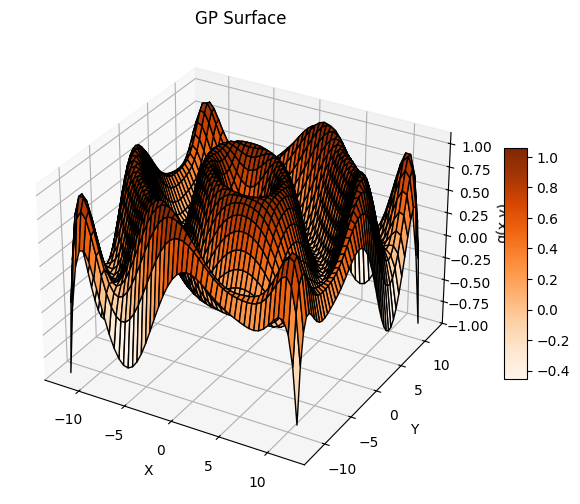

In [7]:
# Example function g(x,y)
def g(x, y):
    r = 0.4*jnp.sqrt(x**2 + x*y + y**2)
    return jnp.sin(r)**2

#training data
x = jnp.linspace(-11, 11, 11)
y = jnp.linspace(-11, 11, 11)
X, Y = jnp.meshgrid(x, y)
xy = jnp.column_stack([X.ravel(), Y.ravel()])
gxy1 = g(xy[:, 0], xy[:, 1])


#evaluation points
x = np.linspace(-12, 12, 50)
y = np.linspace(-12, 12, 50)
X_eval, Y_eval = np.meshgrid(x, y)
xy_eval = np.column_stack([X_eval.ravel(), Y_eval.ravel()])

s = 6
L = jnp.array([4,4])

s, L, m0, x_m, w = jnp.array([s]), [L], jnp.array([2]),jnp.array([0,0]), jnp.array([2,2])
hp_sample = (s,L,m0,x_m,w,0.0)

x,y = reshape(xy,gxy1)
chol_k1, kxx_inv = kinv(xy,hp_sample)
mu_grid, var_eval = gp_predict(
        x, y, xy_eval,
        s=s,L=jnp.diag(L[0]),
        m0=m0,x_m=x_m,w=w,
        K_inv=kxx_inv)
mu_grid = mu_grid.reshape(X_eval.shape)


#calculate function value at random point
x1_test = np.random.uniform(-11, 11, 1)[0]
x2_test = np.random.uniform(-11, 11, 1)[0]
x_test = jnp.array([[x1_test, x2_test]])
y_test = g(x1_test, x2_test)


#predict at same random point
gp_est, gp_var = gp_predict(
    x, y, x_test,
    s=s,L=jnp.diag(L[0]),
    m0=m0,x_m=x_m,w=w,
    K_inv=kxx_inv)
gp_var = gp_var[0]
low = gp_est - 1.96*jnp.sqrt(gp_var)
high = gp_est + 1.96*jnp.sqrt(gp_var)
error = np.abs(y_test - gp_est)


print(f'At X: {x1_test:.3f} and Y: {x2_test:.3f}')
print('--------------------------------------')
print(f'The function value is: {y_test:.4f}')
print(f'The gp estimate is: {gp_est[0]:.4f}')
print(f'The gp std is: {jnp.sqrt(gp_var[0][0]):.4f}')

print(f'Error: {error[0]:.4f}')
print(f'95% CI: [{low[0][0]:.4f}, {high[0][0]:.4f}]')
print()


# Plot GP surface and product surface side by side
fig = plt.figure(figsize=(18, 6))
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
surf1 = ax1.plot_surface(X_eval, Y_eval, mu_grid, cmap="Oranges", edgecolor='k')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('g(x,y)')
fig.colorbar(surf1, ax=ax1, shrink=0.5, aspect=10)
ax1.set_title(f'GP Surface')
plt.show()

### Trivariate Gaussian Process

To demonstrate the Gaussian Process’s capability in modelling smooth three-dimensional functions, the following trivariate function is utilised,
which depends on the radial distance $r = 0.3\sqrt{x^2 + xy + xz + yz + y^2 + z^2}$:

$$
g(x, y, z) = \sin^2(3r) = \sin^2\left(3 \times 0.3\sqrt{x^2 + xy + xz + yz + y^2 + z^2}\right).
$$

A regular grid-based sampling approach is employed here, where the three-dimensional input space is discretised using evenly spaced points generated via `linspace` and `meshgrid`.
This ensures uniform coverage of the domain, providing a consistent basis for visualising and testing the Gaussian Process’s trivariate predictions.


In [8]:
def g3(x, y, z):
    r = 0.3*np.sqrt(x**2 + x*y + x*z + y*z + y**2 + z**2)
    return np.sin(3*r)**2
    

#training data
x = np.linspace(-5, 5, 10)
y = np.linspace(-5, 5, 10)
z = np.linspace(-5, 5, 10)
X, Y, Z = np.meshgrid(x, y, z)
xyz = np.column_stack([X.ravel(), Y.ravel(), Z.ravel()])
gxyz = g3(*xyz.T)

s = 6
L = jnp.array([2,2,2])

s, L, m0, x_m, w = jnp.array([s]), [L], jnp.array([2]),jnp.array([0,0,0]), jnp.array([2,2,2])
hp_sample = (s,L,m0,x_m,w,0.0)

x,y = reshape(xyz,gxyz)
chol_k1, kxx_inv = kinv(xyz,hp_sample)


#predict at same random point
x1_test = np.random.uniform(-5, 5, 1)[0]
x2_test = np.random.uniform(-5, 5, 1)[0]
x3_test = np.random.uniform(-5, 5, 1)[0]
x_test = jnp.array([[x1_test, x2_test,x3_test]])
y_test = g3(x1_test,x2_test,x3_test)

gp_est, gp_var = gp_predict(
    x, y, x_test,
    s=s,L=jnp.diag(L[0]),
    m0=m0,x_m=x_m,w=w,
    K_inv=kxx_inv)
gp_var = gp_var[0]
low = gp_est - 1.96*jnp.sqrt(gp_var)
high = gp_est + 1.96*jnp.sqrt(gp_var)
error = np.abs(y_test - gp_est)


print('--------------------------------------')
print(f'The function value is: {y_test:.4f}')
print(f'The gp estimate is: {gp_est[0]:.4f}')
print(f'The gp std is: {jnp.sqrt(gp_var[0][0]):.4f}')

print(f'Error: {error[0]:.4f}')
print(f'95% CI: [{low[0][0]:.4f}, {high[0][0]:.4f}]')
print()


--------------------------------------
The function value is: 0.1610
The gp estimate is: 0.1788
The gp std is: 0.0161
Error: 0.0178
95% CI: [0.1472, 0.2105]

